In [1]:
import warnings
import logging

from modeling.metrics.display import display_all_confusion_matrices, display_all_roc_curves
from modeling.networks.dataset.quora_bert_dataset import QuestionDataset
from modeling.networks.quora_duplicate_bert import DuplicateTextClassifier

warnings.filterwarnings("ignore")
logging.disable(logging.WARNING)

In [2]:
import torch

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

from transformers import (
    BertTokenizer,
    BertModel,
    Trainer,
    TrainingArguments, DataCollatorWithPadding
)


In [3]:
def choose_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


device = choose_device()
device

device(type='cuda')

In [4]:
df_train = pd.read_csv("../data/raw/quora_question_pairs_train.csv.zip", compression='zip', index_col=0)
df_test = pd.read_csv("../data/raw/quora_question_pairs_test.csv.zip", compression='zip', index_col=0)

df_train.dropna(inplace=True)
df_train.reset_index(inplace=True)

df_train = df_train.sample(n=15000, random_state=42)
df_test = df_test.sample(n=3000, random_state=42)


In [5]:
df_train.size

90000

In [6]:
df_test.size

15000

In [7]:
SAVE_DIR = "../registry/bert/final_model"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_base = BertModel.from_pretrained('bert-base-uncased').to(device)

In [8]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "f1": f1_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
    }

In [9]:
train_df, val_df = train_test_split(df_train, test_size=0.2, stratify=df_train['is_duplicate'], random_state=42)

train_dataset = QuestionDataset(train_df['question1'].values, train_df['question2'].values,
                                train_df['is_duplicate'].values, tokenizer)
val_dataset = QuestionDataset(val_df['question1'].values, val_df['question2'].values,
                              val_df['is_duplicate'].values, tokenizer)
test_dataset = QuestionDataset(df_test['question1'].values,
                               df_test['question2'].values,
                               df_test['is_duplicate'].values,
                               tokenizer)


model = DuplicateTextClassifier(bert_base)

training_args = TrainingArguments(
    output_dir=SAVE_DIR,
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_steps=500,
    lr_scheduler_type="cosine",
    save_strategy="no",
    fp16=True,
    report_to=[]
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

trainer.train()

Step,Training Loss
500,0.499300


TrainOutput(global_step=564, training_loss=0.4816411099535354, metrics={'train_runtime': 1521.7893, 'train_samples_per_second': 23.656, 'train_steps_per_second': 0.371, 'total_flos': 0.0, 'train_loss': 0.4816411099535354, 'epoch': 3.0})

Train - F1: 0.8849, ROC AUC: 0.9623


Validation - F1: 0.7811, ROC AUC: 0.9051


Test - F1: 0.7906, ROC AUC: 0.9078


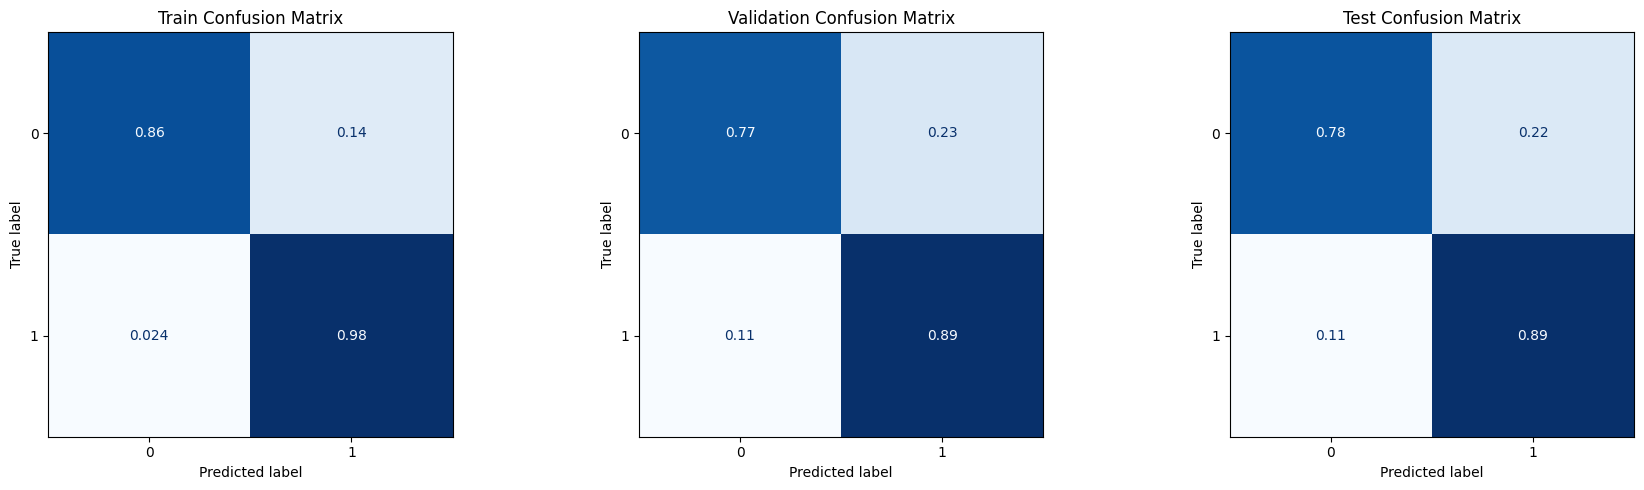

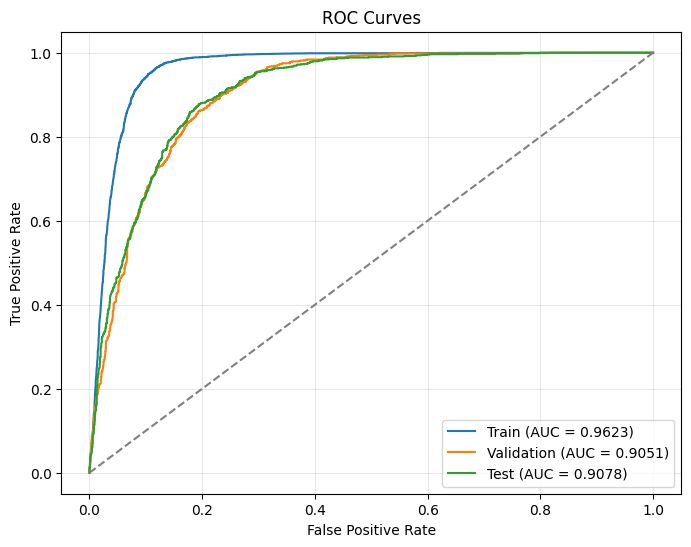

In [10]:
def get_preds_labels_probs(dataset, name):
    outputs = trainer.predict(dataset)
    logits = outputs.predictions

    y_probs = torch.softmax(torch.tensor(logits), dim=1).numpy()[:, 1]
    y_pred = np.argmax(logits, axis=1)
    y_true = np.array(dataset.labels)

    print(f"{name} - F1: {f1_score(y_true, y_pred):.4f}, ROC AUC: {roc_auc_score(y_true, y_probs):.4f}")
    return y_true, y_pred, y_probs


train_y, train_pred, train_probs = get_preds_labels_probs(train_dataset, "Train")
val_y, val_pred, val_probs = get_preds_labels_probs(val_dataset, "Validation")
test_y, test_pred, test_probs = get_preds_labels_probs(test_dataset, "Test")

display_all_confusion_matrices(train_y, val_y, test_y, train_pred, val_pred, test_pred)
display_all_roc_curves(train_y, val_y, test_y, train_probs, val_probs, test_probs)


# Save Model & Tokenizer

In [11]:
trainer.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)
torch.save(model.state_dict(), f"{SAVE_DIR}/pytorch_model.bin")
print(f"Model and tokenizer saved to: {SAVE_DIR}")

Model and tokenizer saved to: ../registry/bert/final_model
